<a href="https://colab.research.google.com/github/e-white25/Working-with-CRIPSR-data-BWA-SAMtools-BCFtools/blob/main/Family_Trio_Variant_Calling_E_White.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Pre-Processing, Rerence Genome Indexing, Alignment, Variant Calling, Filtering, Funcotator**



Download & index reference genome and family trio datasets

In [ ]:
### Our hg38 reference was indexed for us; if not run the first step
!apt install bwa
!apt install samtools
#!apt install bcftools
!bwa index ip hg38.fasta
!wget --no-check-certificate  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz
!gatk-4.3.0.0/gatk CreateSequenceDictionary R=hg38.fa O=hg38.dict

Read Processing: Run QC, Remove adaptor sequences

In [ ]:
### Our data was pre-processed by the Genome in Bottle Consorsium; if it was not pre-processed, here are tools for trimming low-quality reads and adapter sequences
!sudo apt-get install -y default-jre
!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
!unzip fastqc_v0.11.9.zip
!chmod +x FastQC/fastqc
!pip install cutadapt

In [ ]:
# Again, code is included for reference but this step was already completed by the HGBC
!cutadapt --length -65 -o trimmed_Father_L001_R1_001.fastq -p trimmed_Father_L001_R1.001.fastq
!cutadapt --length -65 -o trimmed_Mother_L001_R1_001.fastq -p trimmed_Mother_L001_R1.001.fastq
!cutadapt --length -65 -o trimmed_Son_L001_R1_001.fastq -p trimmed_Son_L001_R1.001.fastq

Alignment:BWA mem to align reads against reference genome

In [ ]:
### General imput structure: bwa mem index_prefix [input_reads.fastq|input_reads_pair_1.fastq input_reads_pair_2.fastq] [options]
!bwa mem -t 32 -R "@RG\tID:Father\tPL:ILLUMINA\tSM:FATHER" ..${dir}}hg.38.fa \
	..${dir}Father_L001_R1_001.fastq.gz  ..${dir}Father_L001_R2_001.fastq.gz > father.paired.sam
!bwa mem -t 32 -R "@RG\tID:Mother\tPL:ILLUMINA\tSM:MOTHER" ..${dir}}hg.38.fa \
	..${dir}Mother.fastq.gz  ..${dir}Mother_L001_R2_001.fastq.gz > mother.paired.sam
!bwa mem -t 32 -R "@RG\tID:Son\tPL:ILLUMINA\tSM:SON" ..${dir}}hg.38.fa \
	..${dir}Son_L001_R1_001.fastq.gz  ..${dir}Son_L001_R2_001.fastq.gz > son.paired.sam

Marking Duplicates & BQSR Local Realignment

In [ ]:
### only done on the father's BAM file, run the following code on each family member
!gatk-4.3.0.0/gatk - father.sorted.paired.sam\
  -O father.sorted.dedup.paired.sam -M metrics

In [ ]:
!gatk-4.3.0.0/gatk BaseRecalibrator -I father_sorted_dedup_reads.bam \
	-R ../hg38.fa --known-sites ../Homo_sapiens_assembly38.dbsnp138.vcf \
	-O recal_data.table

In [ ]:
!gatk-4.3.0.0/gatk ApplyBQSR -I father_sorted_dedup_reads.bam \
	-R ../hg38.fa --bqsr-recal-file recal_data.table \
	-O father_sorted_bqsr_dedup_reads.bam

In [ ]:
!gatk-4.3.0.0/gatk CollectAlignmentSummaryMetrics R=hg38.fa \
	-I father_sorted_bqsr_dedup_reads.bam -O alignment_metrics.txt
../gatk-4.3.0.0/gatk CollectInsertSizeMetrics \
	INPUT=father_sorted_bqsr_dedup_reads.bam \
	OUTPUT=insert_size_metrics.txt HISTOGRAM_FILE=histogram.pdf

Variant Curation

In [ ]:
!gatk-4.3.0.0/gatk HaplotypeCaller -R ../hg38.fa \
	-I father_sorted_bqsr_dedup_reads.bam -O raw_variants.vcf

In [ ]:
# Split VCF into SNPs and INDELS
!gatk-4.3.0.0/gatk SelectVariants -R ../hg38.fa -V raw_variants.vcf --select-type SNP -O raw_snps.vcf
!gatk-4.3.0.0/gatk SelectVariants -R ../hg38.fa -V raw_variants.vcf --select-type INDEL -O raw_indels.vcf

In [ ]:
#Filter INDELS and SNPS
!gatk VariantFiltration \
-R ../hg38.fa \
-V raw_snps.vcf \
-O filtered_snps.vcf \
-filter-name "QD_filter" -filter "QD < 2.0" \
-filter-name "FS_filter" -filter "FS > 60.0" \
-filter-name "MQ_filter" -filter "MQ < 40.0" \
-filter-name "SOR_filter" -filter "SOR > 4.0" \
-filter-name "MQRankSum_filter" -filter "MQRankSum < -12.5" \
-filter-name "ReadPosRankSum_filter" -filter "ReadPosRankSum < -8.0" \
-genotype-filter-expression "DP < 10" \
-genotype-filter-name "DP_filter" \
-genotype-filter-expression "GQ < 10" \
-genotype-filter-name "GQ_filter"

In [ ]:
!gatk-4.3.0.0/gatk SelectVariants \
  --exclude-filtered \
  -V filtered_snps.vcf \
  -O analysis-ready-snps.vcf
  gatk-4.3.0.0/gatk SelectVariants \
  --exclude-filtered \
  -V filtered_indels.vcf \
  -O analysis-ready-indels.vcf

Funcotator: Annotating aligned reads + variant types + position

In [ ]:
#Enable gnomAD (default setting is disabled)
#  cd DATA_SOURCES_DIR
#          tar -zxf gnomAD_exome.tar.gz
#          tar -zxf gnomAD_genome.tar.gz

In [ ]:
!gatk-4.3.0.0/gatk Funcotator --variant analysis-ready-snps-filteredGT-father.vcf \
  --reference ~/hg38.fa --ref-version hg38 --data-sources-path ~/funcotator_dataSources.v1.7.20200521g \
  --output analysis-ready-snps-filteredGT-funcotated-father.vcf --output-file-format VCF

/bin/bash: line 1: gatk-4.3.0.0/gatk: No such file or directory


In [ ]:
!gatk-4.3.0.0/gatk Funcotator --variant analysis-ready-indels-filteredGT.vcf \
  --reference ~/hg38.fa --ref-version hg38 --data-sources-path ~/funcotator_dataSources.v1.7.20200521g \
  --output analysis-ready-indels-filteredGT-funcotated.vcf --output-file-format VCF

In [ ]:
#FuncotatorDataSourceDownloader
!gatk FuncotatorDataSourceDownloader --germline --validate-integrity --extract-after-download

# **Variant Calling: Analysis Section**

Download funcotated VCFs for Family Trio

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive

In [5]:
!cp /content/drive/MyDrive/NGS/father.vcf father.vcf
!cp /content/drive/MyDrive/NGS/mother.vcf mother.vcf
!cp /content/drive/MyDrive/NGS/son.vcf son.vcf

Creating TSVs for each family member: extract specified fields for each variant in a VCF file, output into a tab-delimited table

In [ ]:
!grep '^chr' son.vcf | awk '{print $1":"$2"\t"$8}' | sed 's/FUNCOTATION=\[/\t/g' | sed 's/|/\t/g' | awk '{print $1"\t"$3"\t"$8}' > son_annotation.tsv
!grep '^chr' father.vcf | awk '{print $1":"$2"\t"$8}' | sed 's/FUNCOTATION=\[/\t/g' | sed 's/|/\t/g' | awk '{print $1"\t"$3"\t"$8}' > father_annotation.tsv
!grep '^chr' mother.vcf | awk '{print $1":"$2"\t"$8}' | sed 's/FUNCOTATION=\[/\t/g' | sed 's/|/\t/g' | awk '{print $1"\t"$3"\t"$8}' > mother_annotation.tsv

In [11]:
#creating data frames for manipulation
import pandas

son_df = pandas.read_csv('son_annotation.tsv', delimiter = '\t')
father_df = pandas.read_csv('father_annotation.tsv', delimiter = '\t')
mother_df = pandas.read_csv('mother_annotation.tsv', delimiter = '\t')

In [12]:
columns_annotation = ['ID', 'HUGO', 'CLASSIFICATION']

son_annotation_df = pandas.read_csv('son_annotation.tsv', delimiter = '\t', header=None, names= columns_annotation)
mother_annotation_df = pandas.read_csv('mother_annotation.tsv', delimiter = '\t', header=None, names= columns_annotation)
father_annotation_df = pandas.read_csv('father_annotation.tsv', delimiter = '\t', header=None, names= columns_annotation)


In [ ]:
# process the 3rd field/column from the previous pipeline
# remove duplicate entries
# show how many of each variant type
!awk '{print $3}' son_annotation.tsv | sort | uniq -c

In [ ]:
!awk '{print $3}' mother_annotation.tsv | sort | uniq -c

In [ ]:
!awk '{print $3}' father_annotation.tsv | sort | uniq -c

In [ ]:
#plotting distribution of variants across family
import matplotlib.pyplot as plt
import numpy as np

Member = ("Mother", "Father", "Son")
variant_types = {
    'IGR': (1550812, 1466065, 1525709),
    'Intron':(1295871,1290609, 1250060),
    'RNA': (571007, 548878, 568237),
    "5'Flank": (187859, 179662,186485),
    "3'UTR": (31478 , 30325 , 31081),
    "Missense": (9682, 9314, 9621),
    #"5'UTR": (5874, 5605, 5874),

}

x = np.arange(len(Member))  # the label locations
width = .65  # the width of the bars
multiplier = 1.1

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in variant_types.items():
    offset = width*1.98 * multiplier
    rects = ax.bar(x*2.8 + offset*1.2, measurement, width*1.15, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 0.4

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Variant Count')
ax.set_title('Number of Variant Types across Family Trio')
ax.set_xticks(x*3.2 + width*3.1, Member)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 1650000)

plt.show()

Parse through each VCF file using *cyvcf2*: read & extract file info based on variant annotation and genotype

In [ ]:
!pip install cyvcf2
import cyvcf2

In [ ]:
# 0 indicates the reference allele and 1 indicates the alternative allele, i.e it is heterozygous.
vcf_reader = cyvcf2.VCF('father.vcf')

with open('father_annotation.tsv', 'w') as file:
    for variant in vcf_reader:
        genotype = variant.gt_types[0]
        data_string = f"{variant.CHROM}\t{variant.POS}\t{variant.ID}\t{variant.REF}\t{','.join(variant.ALT)}\t{variant.QUAL}\t{variant.INFO.get('DP')}\t{variant.FILTER}\t{genotype}\n"
        file.write(data_string)

In [16]:
vcf_reader = cyvcf2.VCF('son.vcf')

with open('son_annotation.tsv', 'w') as file:
    for variant in vcf_reader:
        genotype = variant.gt_types[0]
        data_string = f"{variant.CHROM}\t{variant.POS}\t{variant.ID}\t{variant.REF}\t{','.join(variant.ALT)}\t{variant.QUAL}\t{variant.INFO.get('DP')}\t{variant.FILTER}\t{genotype}\n"
        file.write(data_string)

In [ ]:
vcf_reader = cyvcf2.VCF('mother.vcf')

with open('mother_annotation.tsv', 'w') as file:
    for variant in vcf_reader:
        genotype = variant.gt_types[0]
        data_string = f"{variant.CHROM}\t{variant.POS}\t{variant.ID}\t{variant.REF}\t{','.join(variant.ALT)}\t{variant.QUAL}\t{variant.INFO.get('DP')}\t{variant.FILTER}\t{genotype}\n"
        file.write(data_string)

Populate VCF columns with relevant headers

In [ ]:
columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'DP', 'FILTER', 'GENOTYPE']
father_df = pandas.read_csv('father_annotation.tsv', delimiter = '\t', header=None, names= columns)
mother_df = pandas.read_csv('mother_annotation.tsv', delimiter = '\t', header=None, names= columns)
son_df = pandas.read_csv('son_annotation.tsv', delimiter = '\t', header=None, names= columns)

In [ ]:
# populate ID column with CHR:POS (i.e the contig and genomic coordinates on which the variant occurs)
# genome position: one column must contain the contig ID, another column must contain the start position (1-based, inclusive), and a column must contain the stop position (1-based, inclusive)
father_df['ID'] = father_df['CHROM'].astype(str) + ':' + father_df['POS'].astype(str)
mother_df['ID'] = mother_df['CHROM'].astype(str) + ':' + mother_df['POS'].astype(str)
son_df['ID'] = son_df['CHROM'].astype(str) + ':' + son_df['POS'].astype(str)

In [ ]:
# merging the final variant call dataframes with their respective annotations
father_final_df = pandas.merge(father_df, father_annotation_df, on='ID', how='left')
mother_final_df = pandas.merge(mother_df, mother_annotation_df, on='ID', how='left')
son_final_df = pandas.merge(son_df, son_annotation_df, on='ID', how='left')

Creating a Venn Diagram

In [ ]:
!pip install matplotlib matplotlib-venn
import matplotlib.pyplot as plt

In [ ]:
### Filtering by Genotype
hmz_father = father_df[father_df['GENOTYPE'] == 3]['ID'].tolist()
hmz_son = son_df[son_df['GENOTYPE'] == 3]['ID'].tolist()
hmz_mother = mother_df[mother_df['GENOTYPE'] == 3]['ID'].tolist()

In [ ]:
### Documentation: https://pypi.org/project/matplotlib-venn/
!pip install matplotlib matplotlib-venn
from matplotlib_venn import venn3

In [ ]:
### Elements:
set1 = set(hmz_father)
set2 = set(hmz_son)
set3 = set(hmz_mother)

# Create the Venn diagram for two sets
venn3([set1, set3, set2], ('Father', 'Mother', 'Son'))

Variant Identification

In [ ]:
# making a data frame with genes in hpo datbase of genes associated with intellectual disability
# here, we downloaded the gene list above, and created a dataframe
import pandas
dd_genes_df = pandas.read_excel('genes_for_HP_0001249.xlsx')

In [ ]:
# from the ID gene dataframe, we created a list of just the gene names
genes_list = ()
genes_list = dd_genes_df['GENE_SYMBOL'].tolist()
genes_list

SON SPLCE SITE TRANSITIONS/TRANSVERSIONS

In [ ]:
# Transversions: a point mutation in which a single (two ring) purine (A or G) is changed for a (one ring) pyrimidine (T or C), or vice versa

In [ ]:
# SS_transversions_son = (205058662, 54195684, 61398269, 4278918, 123422574,  )
# ss_transitions_son_df = pandas.read_excel('ss_transitions_son.xlsx')
# SS_transitions_son = ()
# SS_transitions_son = ss_transitions_son_df['TRANSITIONS'].tolist()
# SS_transitions =(3138124, 22812901, 24102572, 8163465, 1056066, 7528703, 36084743, 39504071, 49864236, 26386353, 111847725, 134559428, 16018539, 103556978)

son_ID = son_df[son_df['HUGO'].isin(genes_list)]
son_ID
classifications_list = ['SPLICE_SITE']
son_ID = son_ID[son_ID['CLASSIFICATION'].isin(classifications_list)]
son_ID
son_ID_filtered_transversions = son_ID_filtered[son_ID_filtered['POS'].isin(SS_transversions)]
son_ID_filtered_transitions = son_ID_filtered[son_ID_filtered['POS'].isin(SS_transitions)

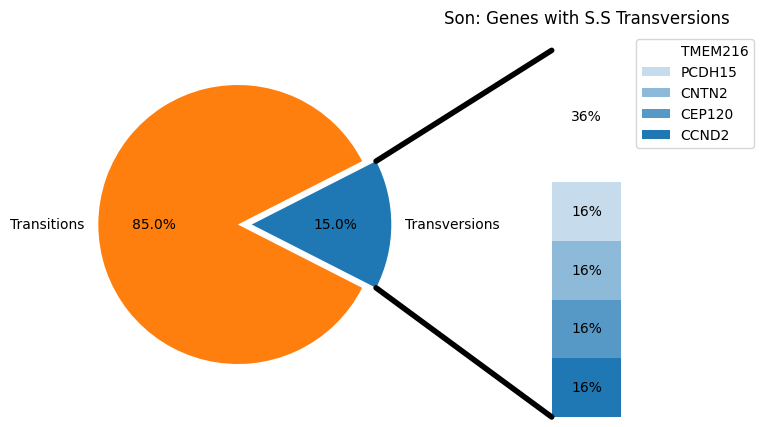

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.15, .85]
labels = ['Transversions', 'Transitions']
explode = [0.1, 0,]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.16, .16, .16, .16, .36]
age_labels = ['CCND2', 'CEP120', 'CNTN2', 'PCDH15', 'TMEM216']
bottom = 1
width = .05

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.0 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Son: Genes with S.S Transversions')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

Father SS transitions/transversions

In [ ]:
father_ID = father_df[father_df['HUGO'].isin(genes_list)]
father_ID

classifications_list = ['SPLICE_SITE']
father_ID_filtered = father_ID[father_ID['CLASSIFICATION'].isin(classifications_list)]
#father_ID_filtered
father_ID_filtered_1 = father_ID_filtered[father_ID_filtered['GENOTYPE'] == 1]
father_ID_filtered_1
# father_ID_filtered_transversions = father_ID_filtered_1[father_ID_filtered_1['POS'].isin(SS_transversions)]
# father_ID_filtered_transitions = father_ID_filtered_1[father_ID_filtered_1['POS'].isin(SS_transitions)]

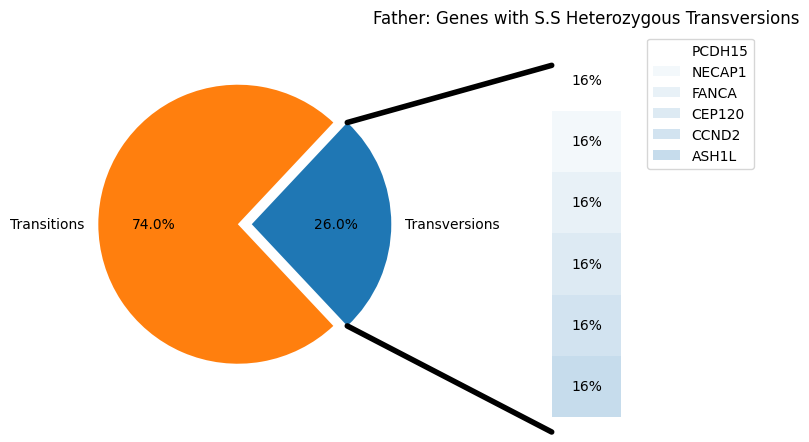

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.26, .74]
labels = ['Transversions', 'Transitions']
explode = [0.1, 0,]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.16, .16, .16, .16, .16, .16]
age_labels = ['ASH1L','CCND2', 'CEP120', 'FANCA', 'NECAP1','PCDH15' ]
bottom = 1
width = .05

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha= 0.000 + 0.05 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Father: Genes with S.S Heterozygous Transversions')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

Mother SS transitions/transversions

In [ ]:
mother_ID = mother_df[mother_df['HUGO'].isin(genes_list)]
mother_ID

classifications_list = ['SPLICE_SITE']
mother_ID_filtered = mother_ID[mother_ID['CLASSIFICATION'].isin(classifications_list)]
mother_ID_filtered
mother_ID_filtered_1 = mother_ID_filtered[mother_ID_filtered['GENOTYPE'] == 1]
# mother_ID_filtered_transversions = mother_ID_filtered_1[mother_ID_filtered_1['POS'].isin(SS_transversions)]
# mother_ID_filtered_transitions = mother_ID_filtered_1[mother_ID_filtered_1['POS'].isin(SS_transitions)]
# Positions:
# SS_transversions = (205058662, 24328283, 55464826)
# SS_transitions =(3138124, 22812901, 24102572, 8163465, 1056066, 7528703, 36084743, 39504071, 49864236, 26386353, 111847725, 134559428, 16018539, 103556978)

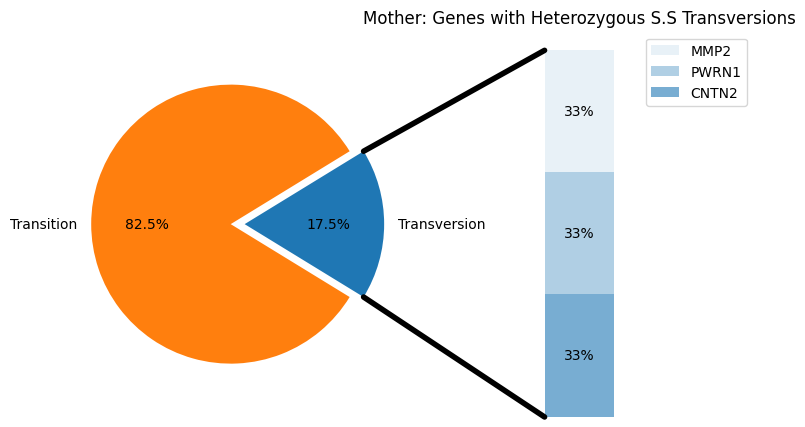

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.175, .825]
labels = ['Transversion', 'Transition']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.333,.333,.333]
age_labels = ['CNTN2', 'PWRN1', 'MMP2']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Mother: Genes with Heterozygous S.S Transversions')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

In [ ]:
#A pie chart for the different types of variants in the son
# (i'm doing this manually because I still have to figure out a better way to plot this)
#import pandas
#SON
import plotly.graph_objects as go
Classifications = ['COULD_NOT_DETERMINE', ' DE_NOVO_START_IN_FRAME', 'DE_NOVO_START_OUT_FRAME', 'FIVE_PRIME_FLANK', 'FIVE_PRIME_UTR', 'IGR', 'INTRON', 'MISSENSE', 'NONSENSE', 'NONSTOP','RNA', 'SILENT','SPLICE_SITE', 'START_CODON_SNP', 'THREE_PRIME_UTR']
Variants = [1732, 27, 62, 186485, 5874, 1525709, 1290609, 9621, 77, 16, 568237, 10589, 878, 7, 31081]

fig = go.Figure(data=go.Pie(
    labels=Classifications,
    values=Variants
))
fig.show()
#FATHER
import plotly.graph_objects as go
Classifications = ['COULD_NOT_DETERMINE', ' DE_NOVO_START_IN_FRAME', 'DE_NOVO_START_OUT_FRAME', 'FIVE_PRIME_FLANK', 'FIVE_PRIME_UTR', 'IGR', 'INTRON', 'MISSENSE', 'NONSENSE', 'NONSTOP','RNA', 'SILENT','SPLICE_SITE', 'START_CODON_SNP', 'THREE_PRIME_UTR']
Variants = [1732, 27, 62, 186485, 5874, 1525709, 1290609, 9621, 77, 16, 568237, 10589, 878, 7, 31081]

fig = go.Figure(data=go.Pie(
    labels=Classifications,
    values=Variants
))
fig.show()
#MOTHER

import plotly.graph_objects as go
Classifications = ['COULD_NOT_DETERMINE', ' DE_NOVO_START_IN_FRAME', 'DE_NOVO_START_OUT_FRAME', 'FIVE_PRIME_FLANK', 'FIVE_PRIME_UTR', 'IGR', 'INTRON', 'MISSENSE', 'NONSENSE', 'NONSTOP','RNA', 'SILENT','SPLICE_SITE', 'START_CODON_SNP', 'THREE_PRIME_UTR']
Variants = [1732, 27, 62, 186485, 5874, 1525709, 1290609, 9621, 77, 16, 568237, 10589, 878, 7, 31081]

fig = go.Figure(data=go.Pie(
    labels=Classifications,
    values=Variants
))
fig.show()

# **Finding Variants for Curation**

In [ ]:
# If we want to filter for homozygous variants
hmzson_ID_filtered = son_ID_filtered[son_ID_filtered['GENOTYPE']== 3]

In [ ]:
#If we want to count how many genes are in either filtered list
son_ID_filtered.count()
hmzson_ID_filtered.count()
#another way to count variants:
len(hmzson_ID_filtered)

In [ ]:
# we selected variants with gene names matching those from hpo ID gene list
# https://hpo.jax.org/app/browse/term/HP:0002194
son_ID_genes = son_df[son_df['HUGO'].isin(genes_list)]
son_ID_genes

In [ ]:
# filtering matches with more likely-pathogenic variant types
classifications_list = ('SPLICE_SITE', 'DE_NOVO_START_OUT_FRAME', 'NONSENSE', 'MISSENSE')
son_ID_filtered = son_ID_genes[son_ID_genes['CLASSIFICATION'].isin(classifications_list)]
son_ID_filtered

In [ ]:
son_ID_genes = son_ID_genes[son_ID_genes['HUGO'].isin(genes_list)]
son_ID_genes_HECW2 = son_ID_genes[son_ID_genes['HUGO']=='HECW2']
son_ID_genes_HECW2

In [ ]:
# Selecting only variants for a specific gene of interest
son_gene = son_df[son_df['HUGO'] == 'HECW2']
son_gene_variant = son_gene[son_gene['CLASSIFICATION'] == 'FIVE_PRIME_UTR']
son_gene_variant

In [ ]:
#confirming if the variant is present in the father & mother
# father_HEW2 = father_ID_filtered[father_ID_filtered['HUGO']=='HEW2']
# father_HEW2
mom_HECW2_df = mother_df[mother_df['HUGO']=='HECW2']
mom_HECW2_df.count()

variant_MH = mom_HECW2_df[mom_HECW2_df['CLASSIFICATION']=='INTRON']
variant_MH.count()

In [ ]:
mom_HECW2_INTRON = ()
mom_HECW2_INTRON = variant_MH['POS'].tolist()
#mom_HECW2_INTRON
son_gene_variant[son_gene_variant['POS'].isin(mom_HECW2_INTRON)]

In [ ]:
# counts associated with HECW2 variants
son_ID_genes_HECW2_variant = son_ID_genes_HECW2[son_ID_genes_HECW2['CLASSIFICATION']=='SILENT']
son_ID_genes_HECW2_variant.count()

In [ ]:
#de-novo variants
total_mom = ()
total_mom = mother_df['POS'].tolist()

total_dad = ()
total_dad = father_df['POS'].tolist()

In [ ]:
mother_son = son_df[son_df['POS'].isin(total_mom)]
mother_son.count()

In [ ]:
father_son = son_df[son_df['POS'].isin(total_dad)]
father_son.count()

In [ ]:
Mother_father = father_df[father_df['POS'].isin(total_mom)]
Mother_father.count()

In [ ]:
Mother_father_list = ()
Mother_father_list = Mother_father['POS'].tolist()

In [ ]:
all_three = son_df[son_df['POS'].isin(Mother_father_list)]
all_three.count()

In [ ]:
father_FLG = father_df[father_df['POS']== 152308194]
father_FLG

In [ ]:
father_TMEM = father_ID_filtered[father_ID_filtered['HUGO']== 'TMEM216']
father_TMEM

In [ ]:
mother_TMEM = mother_ID_filtered[mother_ID_filtered['HUGO']== 'TMEM216']
mother_TMEM

In [ ]:
# son_ID_filtered_PCDH15 = son_df[son_df['HUGO']=='PCDH15']
# son_ID_filtered_PCDH15_interst = son_ID_filtered_PCDH15[son_ID_filtered_PCDH15['CLASSIFICATION']=='DE_NOVO_START']
classifications_list = ['DE_NOVO_START_IN_FRAME']
son_ID = son_ID[son_ID['CLASSIFICATION'].isin(classifications_list)]
son_ID

In [ ]:
classifications_list = ['NONSENSE']
son_ID_int = son_ID[son_ID['CLASSIFICATION'].isin(classifications_list)]
son_ID_int

In [ ]:
mother_FLG = mother_df[mother_df['POS']== 152308194]
mother_FLG